In [ ]:
!pip install XGBoost

# XGBoost

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/output.csv', parse_dates=['date'], index_col='date', date_parser=lambda x: pd.to_datetime(x, format='%m - %y'))


<ipython-input-4-8742fe4b255c>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/drive/MyDrive/output.csv', parse_dates=['date'], index_col='date', date_parser=lambda x: pd.to_datetime(x, format='%m - %y'))


In [ ]:
df1 = df.copy()

In [ ]:
df.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01',
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01'],
              dtype='datetime64[ns]', name='date', length=284, freq=None)

In [ ]:
df

,temperature,dew_point_temp,relative_humidity,wind_speed,Generation(megawatthrs)
date,,,,,
2001-01-01,42.190726,35.136290,78.836720,9.096438,22450.33300
2001-02-01,49.616939,42.020505,78.083224,11.216791,18357.42100
2001-03-01,51.574697,43.343203,75.897429,8.918304,19481.59100
2001-04-01,68.038889,56.945833,69.980333,12.198398,20094.17500
2001-05-01,74.154987,63.415094,71.371119,11.163679,23729.52600
...,...,...,...,...,...
2024-04-01,68.681250,56.426389,68.500514,12.483889,5305.85996
2024-05-01,76.885753,66.099462,71.643253,10.615860,7725.75821
2024-06-01,83.967500,70.156944,65.470833,9.933125,8788.78330


In [ ]:
# 1  Generate the complete month-start index from first to last date
full_idx = pd.date_range(df.index.min(), df.index.max(), freq='MS')


In [ ]:
# 2  Identify any months that are missing
missing_months = full_idx.difference(df.index)
print("Missing months:", missing_months)

Missing months: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')


In [ ]:
# 3  Re-index to that complete range (adds NaNs where data is absent)
df = df.reindex(full_idx)



In [ ]:
# 4  Set the frequency flag explicitly
df = df.asfreq('MS')

In [ ]:
df.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01',
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01'],
              dtype='datetime64[ns]', length=284, freq='MS')

# Data Preparation





**Feature Engineering**

In [ ]:
# Feature engineering
df['gen_lag_1']  = df['Generation(megawatthrs)'].shift(1)
df['gen_lag_2']  = df['Generation(megawatthrs)'].shift(2)
df['gen_lag_12'] = df['Generation(megawatthrs)'].shift(12)


In [ ]:
df['gen_roll_3']  = df['Generation(megawatthrs)'].rolling(3).mean()
df['gen_roll_6']  = df['Generation(megawatthrs)'].rolling(6).mean()
df['gen_roll_12'] = df['Generation(megawatthrs)'].rolling(12).mean()

In [ ]:
df['month_num'] = df.index.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

In [ ]:
df

,temperature,dew_point_temp,relative_humidity,wind_speed,Generation(megawatthrs),gen_lag_1,gen_lag_2,gen_lag_12,gen_roll_3,gen_roll_6,gen_roll_12,month_num,month_sin,month_cos
2001-01-01,42.190726,35.136290,78.836720,9.096438,22450.33300,NaN,NaN,NaN,NaN,NaN,NaN,1,5.000000e-01,8.660254e-01
2001-02-01,49.616939,42.020505,78.083224,11.216791,18357.42100,22450.33300,NaN,NaN,NaN,NaN,NaN,2,8.660254e-01,5.000000e-01
2001-03-01,51.574697,43.343203,75.897429,8.918304,19481.59100,18357.42100,22450.33300,NaN,20096.448333,NaN,NaN,3,1.000000e+00,6.123234e-17
2001-04-01,68.038889,56.945833,69.980333,12.198398,20094.17500,19481.59100,18357.42100,NaN,19311.062333,NaN,NaN,4,8.660254e-01,-5.000000e-01
2001-05-01,74.154987,63.415094,71.371119,11.163679,23729.52600,20094.17500,19481.59100,NaN,21101.764000,NaN,NaN,5,5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,68.681250,56.426389,68.500514,12.483889,5305.85996,5693.67136,4962.28861,4871.89542,5320.606643,5726.438497,7278.783342,4,8.660254e-01,-5.000000e-01
2024-05-01,76.885753,66.099462,71.643253,10.615860,7725.75821,5305.85996,5693.67136,7029.36674,6241.763177,6161.846852,7336.815964,5,5.000000e-01,-8.660254e-01
2024-06-01,83.967500,70.156944,65.470833,9.933125,8788.78330,7725.75821,5305.85996,8875.69526,7273.467157,6688.440882,7329.573301,6,1.224647e-16,-1.000000e+00
2024-07-01,84.806191,69.528937,62.654482,9.711456,9609.18538,8788.78330,7725.75821,10347.16390,8707.908963,7014.257803,7268.075091,7,-5.000000e-01,-8.660254e-01


In [ ]:
df = df.dropna()

**Test-Train-Val Split**

In [ ]:
train_size = int(len(df) * 0.70)
val_size   = int(len(df) * 0.15)

In [ ]:
train_df = df.iloc[:train_size]
val_df   = df.iloc[train_size:train_size + val_size]
test_df  = df.iloc[train_size + val_size:]

In [ ]:
print("Training set dates:", train_df.index.min(), "to", train_df.index.max())
print("Validation set dates:", val_df.index.min(), "to", val_df.index.max())
print("Test set dates:", test_df.index.min(), "to", test_df.index.max())

Training set dates: 2002-01-01 00:00:00 to 2017-10-01 00:00:00
Validation set dates: 2017-11-01 00:00:00 to 2021-02-01 00:00:00
Test set dates: 2021-03-01 00:00:00 to 2024-08-01 00:00:00


In [ ]:
feature_cols = [
    'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed',
    'gen_lag_1', 'gen_lag_2', 'gen_lag_12',
    'gen_roll_3', 'gen_roll_6', 'gen_roll_12',
    'month_sin', 'month_cos'
]


In [ ]:
X_train, y_train = train_df[feature_cols], train_df['Generation(megawatthrs)']
X_val,   y_val   = val_df[feature_cols],   val_df['Generation(megawatthrs)']
X_test,  y_test  = test_df[feature_cols],  test_df['Generation(megawatthrs)']

# Model Training

**Baseline model**

In [ ]:
from xgboost import XGBRegressor, callback
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

In [ ]:
import xgboost as xgb
print("xgboost version →", xgb.__version__)

xgboost version → 2.1.4


In [ ]:
early_stop = callback.EarlyStopping(rounds=50, save_best=True)

In [ ]:
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    eval_metric='mape',
    early_stopping_rounds=50,    # stop if val-MAPE hasn’t improved in 50 rounds
    random_state=42
)


In [ ]:
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

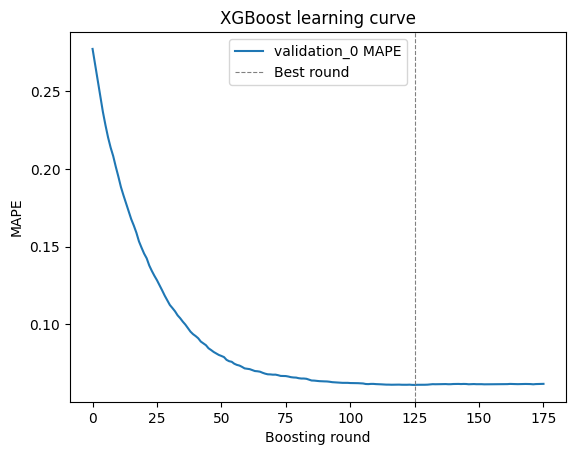

In [ ]:
import matplotlib.pyplot as plt

history = model.evals_result_ if hasattr(model, "evals_result_") else model.evals_result()

for key, metrics in history.items():          # key = 'validation_0', 'validation_1', etc.
    plt.plot(metrics['mape'], label=f"{key} MAPE")

plt.axvline(model.best_iteration, color='grey', ls='--', lw=0.8, label='Best round')
plt.xlabel('Boosting round')
plt.ylabel('MAPE')
plt.title('XGBoost learning curve')
plt.legend()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
mape   = mean_absolute_percentage_error(y_test, y_pred)
print(f"Test MAPE: {mape*100:.2f}%")

Test MAPE: 6.00%


In [ ]:
print(f"Best round : {model.best_iteration}")
print(f"Test MAPE  : {mape*100:.2f}%")          # test set you computed

Best round : 125
Test MAPE  : 6.00%


**Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from xgboost import XGBRegressor
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

param_dist = {
    "n_estimators":      np.arange(300, 1400, 200),
    "learning_rate":     [0.01, 0.03, 0.05, 0.07, 0.1],
    "max_depth":         [3, 4, 5, 6],
    "min_child_weight":  [1, 3, 5],
    "subsample":         [0.6, 0.8, 1.0],
    "colsample_bytree":  [0.6, 0.8, 1.0],
    "gamma":             [0, 0.05, 0.15, 0.3],
    "reg_lambda":        [1, 1.5, 2]
}

base_model = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mape",
    random_state=42,
    n_jobs=-1
)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=40,
    cv=tscv,
    scoring=mape_scorer,
    verbose=0,
    random_state=42,
    refit=True
)


In [ ]:
search.fit(X_train, y_train)


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='mape',
                                          feature_types=None, gamma=None,
                                          grow_policy=...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.05, 0.15, 0.3],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.07, 0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': array([ 300,  500,  700,  900, 1100, 1300]),
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False, response_method='predict'))

In [ ]:
best_model = search.best_estimator_

In [ ]:
y_pred  = best_model.predict(X_test)
mape_ts = mean_absolute_percentage_error(y_test, y_pred)

In [ ]:
print("Best parameters :", search.best_params_)
print(f"Time-series CV MAPE (neg): {search.best_score_:.5f}")
print(f"Test MAPE                : {mape_ts*100:.2f}%")

Best parameters : {'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': np.int64(1300), 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Time-series CV MAPE (neg): -0.06460
Test MAPE                : 5.71%


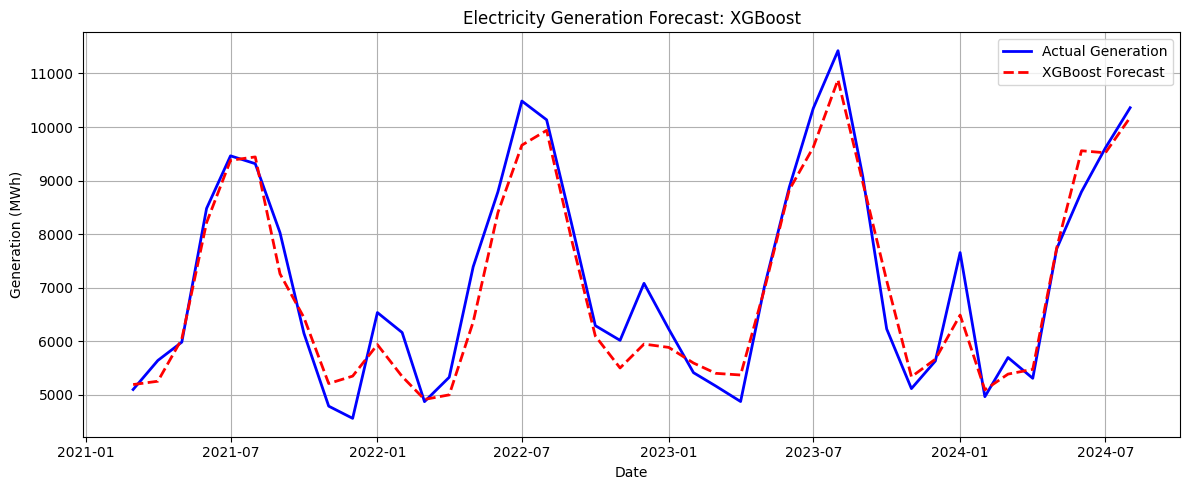

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Actual Generation
plt.plot(y_test.index, y_test, label="Actual Generation", color='blue', linewidth=2)

# XGBoost Forecast
plt.plot(y_test.index, y_pred, label="XGBoost Forecast", linestyle='--', color='red', linewidth=2)

# Labels and Formatting
plt.title("Electricity Generation Forecast: XGBoost")
plt.xlabel("Date")
plt.ylabel("Generation (MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Feature Importance**

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

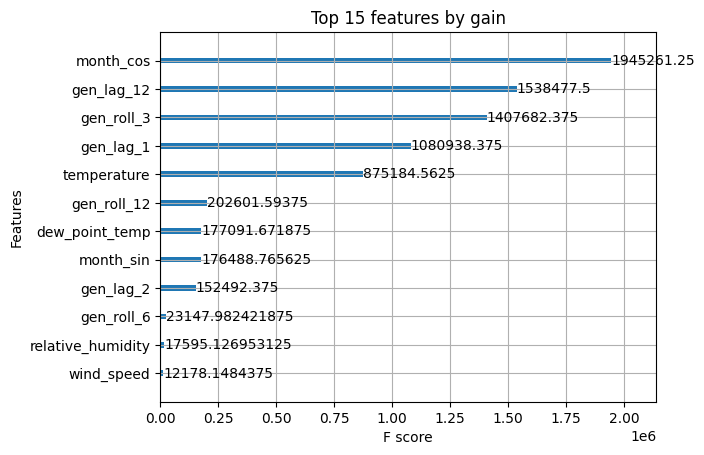

In [ ]:
plot_importance(best_model, importance_type='gain', max_num_features=15)
plt.title("Top 15 features by gain")
plt.show()

In [ ]:
!pip install shap

<ipython-input-40-40df68572ccb>:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")   # global


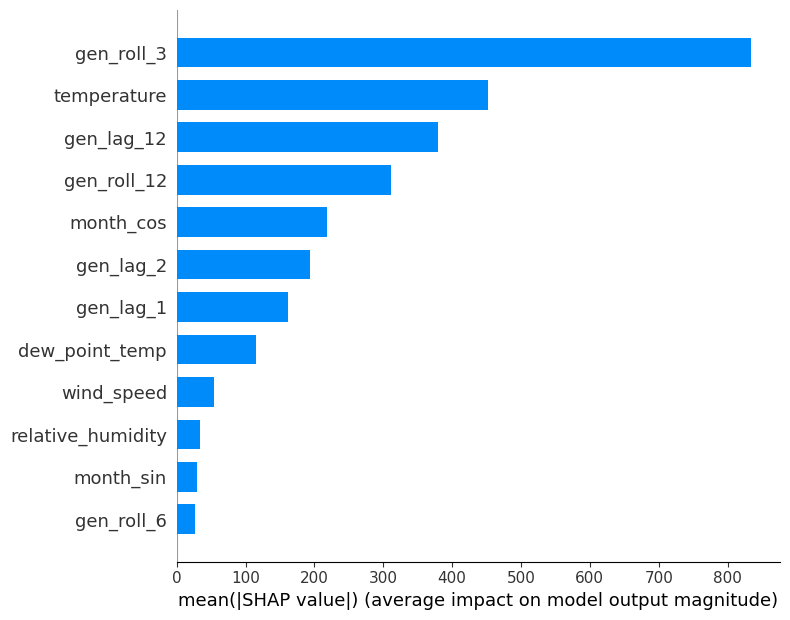

In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best_model)          # tuned XGB
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")   # global
shap.force_plot(explainer.expected_value, shap_values[-1], X_test.iloc[-1])  # single month


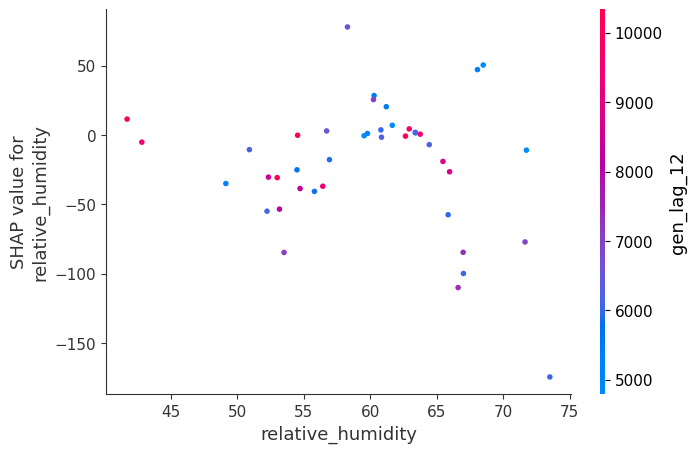

In [ ]:
shap.dependence_plot("relative_humidity", shap_values, X_test)


# VAR

In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_absolute_percentage_error



In [ ]:
df1

,temperature,dew_point_temp,relative_humidity,wind_speed,Generation(megawatthrs)
date,,,,,
2001-01-01,42.190726,35.136290,78.836720,9.096438,22450.33300
2001-02-01,49.616939,42.020505,78.083224,11.216791,18357.42100
2001-03-01,51.574697,43.343203,75.897429,8.918304,19481.59100
2001-04-01,68.038889,56.945833,69.980333,12.198398,20094.17500
2001-05-01,74.154987,63.415094,71.371119,11.163679,23729.52600
...,...,...,...,...,...
2024-04-01,68.681250,56.426389,68.500514,12.483889,5305.85996
2024-05-01,76.885753,66.099462,71.643253,10.615860,7725.75821
2024-06-01,83.967500,70.156944,65.470833,9.933125,8788.78330


In [ ]:
def check_stationarity(series, name):
    adf_p = adfuller(series.dropna())[1]
    kpss_p = kpss(series.dropna(), nlags="auto")[1]
    print(f"{name:20} | ADF p-value: {adf_p:.4f} | KPSS p-value: {kpss_p:.4f}")

for col in df1.columns:
    check_stationarity(df1[col], col)




temperature          | ADF p-value: 0.1242 | KPSS p-value: 0.1000
dew_point_temp       | ADF p-value: 0.0238 | KPSS p-value: 0.1000
relative_humidity    | ADF p-value: 0.0000 | KPSS p-value: 0.1000
wind_speed           | ADF p-value: 0.0000 | KPSS p-value: 0.1000
Generation(megawatthrs) | ADF p-value: 0.0000 | KPSS p-value: 0.0100


<ipython-input-45-e73d083d6d32>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series.dropna(), nlags="auto")[1]
<ipython-input-45-e73d083d6d32>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series.dropna(), nlags="auto")[1]
<ipython-input-45-e73d083d6d32>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series.dropna(), nlags="auto")[1]
<ipython-input-45-e73d083d6d32>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series.dropna(), nlags="au

In [ ]:
df_stationary = df1.copy()

In [ ]:
df_stationary['temperature_diff'] = df_stationary['temperature'].diff()

In [ ]:
# Drop original temperature to avoid confusion
df_stationary = df_stationary.drop(columns=['temperature']).dropna()

In [ ]:
# Verify again:
check_stationarity(df_stationary['temperature_diff'], "temperature_diff")

temperature_diff     | ADF p-value: 0.0000 | KPSS p-value: 0.1000


<ipython-input-45-e73d083d6d32>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series.dropna(), nlags="auto")[1]


In [ ]:
# Ensure df_stationary has identical dates as original df after differencing
df_stationary = df_stationary.loc[df.index].dropna()

# Get exact split dates from XGBoost splits:
train_end_date = train_df.index[-1]
val_start_date = val_df.index[0]
val_end_date = val_df.index[-1]
test_start_date = test_df.index[0]

# Match these splits exactly for VAR:
train_var_df = df_stationary.loc[:train_end_date]
val_var_df   = df_stationary.loc[val_start_date:val_end_date]
test_var_df  = df_stationary.loc[test_start_date:]


In [ ]:
train_var_df, test_var_df

(            dew_point_temp  relative_humidity  wind_speed  \
 2002-01-01       33.956044          63.364025   10.968145   
 2002-02-01       32.104948          60.361739   10.732759   
 2002-03-01       41.698910          67.779360   13.704036   
 2002-04-01       58.121429          72.937243   12.469286   
 2002-05-01       61.749641          71.248633   11.916160   
 ...                    ...                ...         ...   
 2017-06-01       69.347280          68.207238   10.399930   
 2017-07-01       71.507402          63.350269    8.695424   
 2017-08-01       70.873656          67.192446    8.759838   
 2017-09-01       62.758333          58.066847    8.914097   
 2017-10-01       50.082075          53.598760   10.303504   
 
             Generation(megawatthrs)  temperature_diff  
 2002-01-01              12160.43300         -2.260456  
 2002-02-01              10746.05200         -0.389715  
 2002-03-01              11501.99000          6.643289  
 2002-04-01              1

In [ ]:
print("Training set dates:", train_var_df.index.min(), "to", train_var_df.index.max())
print("Validation set dates:", val_var_df.index.min(), "to", val_var_df.index.max())
print("Test set dates:", test_var_df.index.min(), "to", test_var_df.index.max())



Training set dates: 2002-01-01 00:00:00 to 2017-10-01 00:00:00
Validation set dates: 2017-11-01 00:00:00 to 2021-02-01 00:00:00
Test set dates: 2021-03-01 00:00:00 to 2024-08-01 00:00:00


In [ ]:
model1 = VAR(train_var_df)
lag_results = model1.select_order(maxlags=12)
selected_lag = lag_results.aic
print("Selected lag order (AIC):", selected_lag)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Selected lag order (AIC): 11


In [ ]:
var_result = model1.fit(selected_lag)
print(var_result.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 24, Apr, 2025
Time:                     06:14:36
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    22.7505
Nobs:                     179.000    HQIC:                   19.7863
Log likelihood:          -2579.88    FPE:                5.78359e+07
AIC:                      17.7646    Det(Omega_mle):     1.48294e+07
--------------------------------------------------------------------
Results for equation dew_point_temp
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               4.437049        14.420536            0.308           0.758
L1.dew_point_temp                   1.463110         0.725997            2.015           0

In [ ]:
# Concatenate train and validation sets for accurate forecasting into test
train_val_df = pd.concat([train_var_df, val_var_df])
forecast_input = train_val_df.values[-selected_lag:]
forecast_steps = len(test_var_df)



In [ ]:
forecast = var_result.forecast(y=forecast_input, steps=forecast_steps)

In [ ]:
# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=test_var_df.index, columns=test_var_df.columns)

In [ ]:
forecast_df

,dew_point_temp,relative_humidity,wind_speed,Generation(megawatthrs),temperature_diff
2021-03-01,42.728192,64.104128,11.649660,6245.821309,15.868214
2021-04-01,53.804189,72.105711,11.841673,6182.615006,7.302315
2021-05-01,63.082155,67.366507,11.099105,7042.831377,11.812536
2021-06-01,68.532694,64.194826,11.086650,8307.144930,7.432546
2021-07-01,69.599662,60.401020,9.646289,9752.734754,3.402234
2021-08-01,67.279436,57.815211,7.859833,10273.365797,-0.678853
2021-09-01,62.322451,61.656886,7.339894,8936.395375,-7.296835
2021-10-01,54.041222,58.206652,8.763682,7409.423003,-7.101480
2021-11-01,45.629533,64.855298,10.228705,5874.090331,-12.377116
2021-12-01,35.384085,63.428584,10.172739,6045.134740,-10.108021


In [ ]:
# Temperature restoration
last_temp_train_val = df["temperature"].loc[train_val_df.index[-1]]
forecast_df["temperature_forecast"] = last_temp_train_val + forecast_df["temperature_diff"].cumsum()


In [ ]:
forecast_df

,dew_point_temp,relative_humidity,wind_speed,Generation(megawatthrs),temperature_diff,temperature_forecast
2021-03-01,42.728192,64.104128,11.649660,6245.821309,15.868214,56.557648
2021-04-01,53.804189,72.105711,11.841673,6182.615006,7.302315,63.859963
2021-05-01,63.082155,67.366507,11.099105,7042.831377,11.812536,75.672499
2021-06-01,68.532694,64.194826,11.086650,8307.144930,7.432546,83.105045
2021-07-01,69.599662,60.401020,9.646289,9752.734754,3.402234,86.507279
2021-08-01,67.279436,57.815211,7.859833,10273.365797,-0.678853,85.828426
2021-09-01,62.322451,61.656886,7.339894,8936.395375,-7.296835,78.531591
2021-10-01,54.041222,58.206652,8.763682,7409.423003,-7.101480,71.430112
2021-11-01,45.629533,64.855298,10.228705,5874.090331,-12.377116,59.052995
2021-12-01,35.384085,63.428584,10.172739,6045.134740,-10.108021,48.944975


In [ ]:
# Generation accuracy
actual_gen = test_var_df["Generation(megawatthrs)"]
forecast_gen = forecast_df["Generation(megawatthrs)"]
mape_gen = mean_absolute_percentage_error(actual_gen, forecast_gen)

print(f"Generation Forecast MAPE: {mape_gen*100:.2f}%")



Generation Forecast MAPE: 13.75%


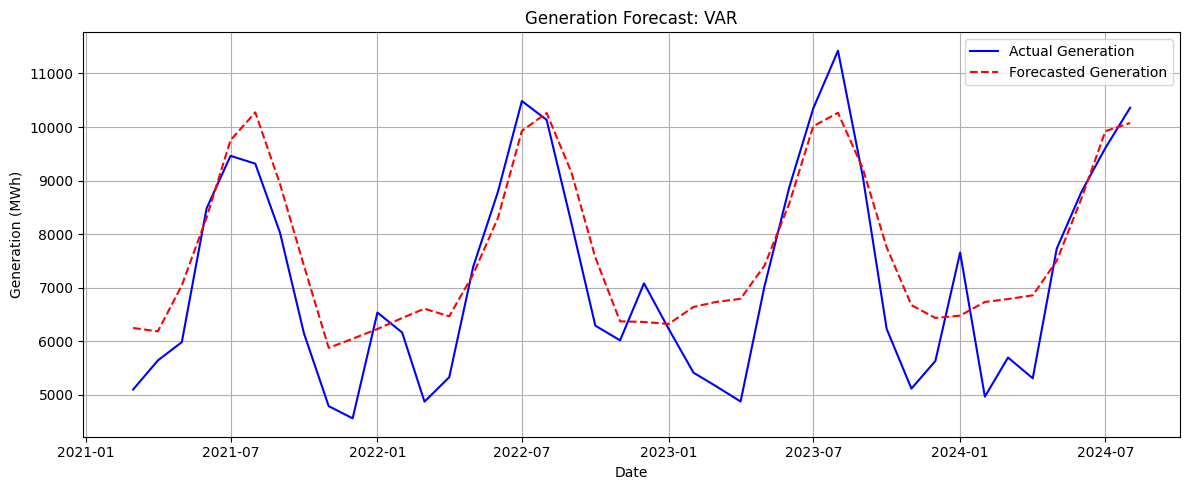

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(actual_gen.index, actual_gen, label="Actual Generation", color='blue')
plt.plot(forecast_df.index, forecast_gen, label="Forecasted Generation", linestyle='--', color='red')
plt.title("Generation Forecast: VAR")
plt.xlabel("Date")
plt.ylabel("Generation (MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


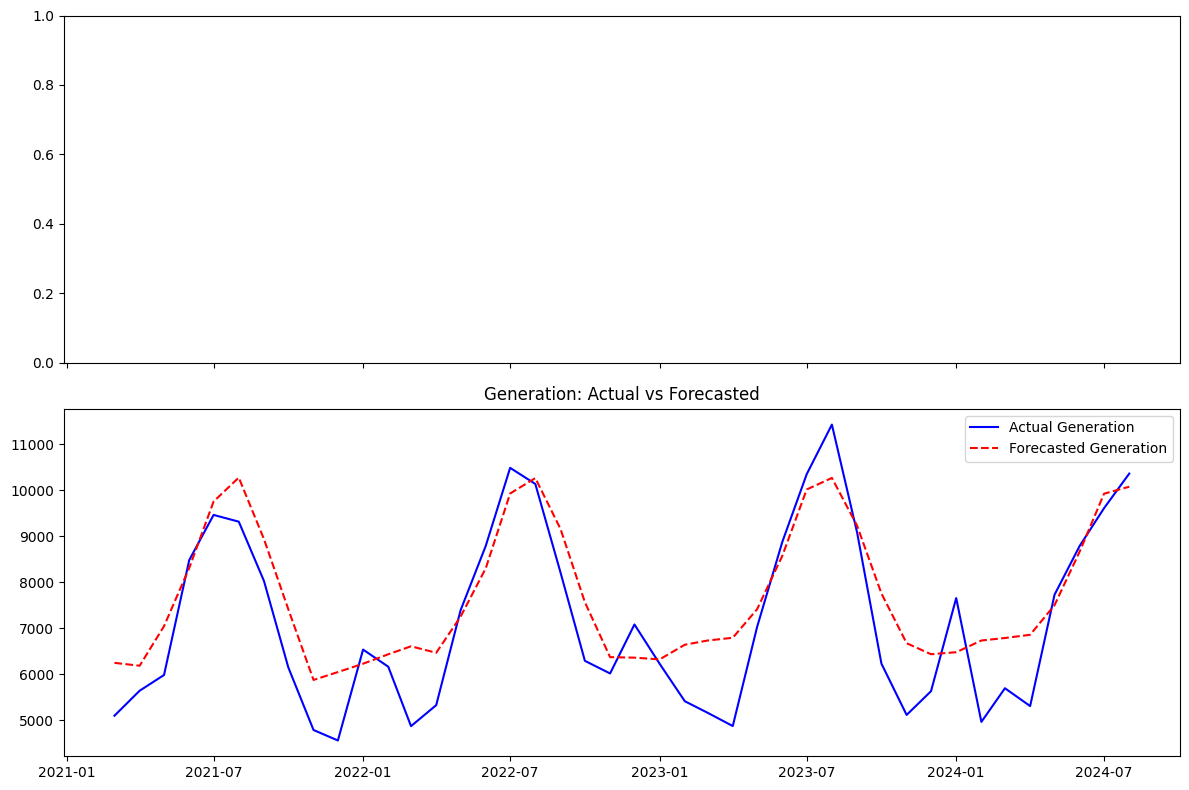

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# axes[0].plot(actual_temp.index, actual_temp, label="Actual Temp", color='blue')
# axes[0].plot(forecast_df.index, forecast_df["temperature_forecast"], label="Forecasted Temp", linestyle='--', color='red')
# axes[0].set_title("Temperature: Actual vs Forecasted")
# axes[0].legend()

axes[1].plot(actual_gen.index, actual_gen, label="Actual Generation", color='blue')
axes[1].plot(forecast_df.index, forecast_gen, label="Forecasted Generation", linestyle='--', color='red')
axes[1].set_title("Generation: Actual vs Forecasted")
axes[1].legend()

plt.tight_layout()
plt.show()


# SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


In [ ]:
# Confirm you have df and exogenous variables
target = df["Generation(megawatthrs)"]
exog = df[["temperature", "relative_humidity", "wind_speed",'dew_point_temp']]



In [ ]:
# Use same XGBoost-style splits
train_size = int(len(df) * 0.70)
val_size = int(len(df) * 0.15)

In [ ]:
y_train = target.iloc[:train_size]
X_train = exog.iloc[:train_size]

y_val = target.iloc[train_size:train_size + val_size]
X_val = exog.iloc[train_size:train_size + val_size]

y_test = target.iloc[train_size + val_size:]
X_test = exog.iloc[train_size + val_size:]

In [ ]:
# Combine train + val data
y_train_val = pd.concat([y_train, y_val])
X_train_val = pd.concat([X_train, X_val])

# Confirm shapes
print(y_train_val.shape, y_test.shape)


(230,) (42,)


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.1 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_val_scaled = pd.DataFrame(scaler.fit_transform(X_train_val), index=X_train_val.index, columns=X_train_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model2 = SARIMAX(
    endog=y_train_val,
    exog=X_train_val_scaled,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)






In [ ]:
results = model2.fit(disp=False)

In [ ]:
forecast_test = results.get_forecast(steps=len(y_test), exog=X_test_scaled)
pred_test = forecast_test.predicted_mean


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mape_test = mean_absolute_percentage_error(y_test, pred_test)
print(f"Test MAPE (SARIMAX, scaled exog): {mape_test*100:.2f}%")


Test MAPE (SARIMAX, scaled exog): 9.24%


In [ ]:
# import itertools

# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, [1], q))
# seasonal_pdq = [(x[0], 1, x[2], 12) for x in pdq]

# best_aic = float("inf")
# best_model = None

# for param in pdq:
#     for seasonal in seasonal_pdq:
#         try:
#             mod = SARIMAX(y_train_val, exog=X_train_val_scaled,
#                           order=param, seasonal_order=seasonal,
#                           enforce_stationarity=False, enforce_invertibility=False)
#             res = mod.fit(disp=False)
#             if res.aic < best_aic:
#                 best_aic = res.aic
#                 best_model = res
#                 print(f"New best AIC: {best_aic:.2f} for order={param}, seasonal_order={seasonal}")
#         except:
#             continue


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_best = SARIMAX(
    endog=y_train_val,
    exog=X_train_val_scaled,
    order=(1, 1, 2),
    seasonal_order=(1, 1, 2, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_best = model_best.fit(disp=False)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast_best = results_best.get_forecast(steps=len(y_test), exog=X_test_scaled)
pred_test_best = forecast_best.predicted_mean


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mape_best = mean_absolute_percentage_error(y_test, pred_test_best)
print(f"Test MAPE (SARIMAX best tuned): {mape_best*100:.2f}%")


Test MAPE (SARIMAX best tuned): 8.24%


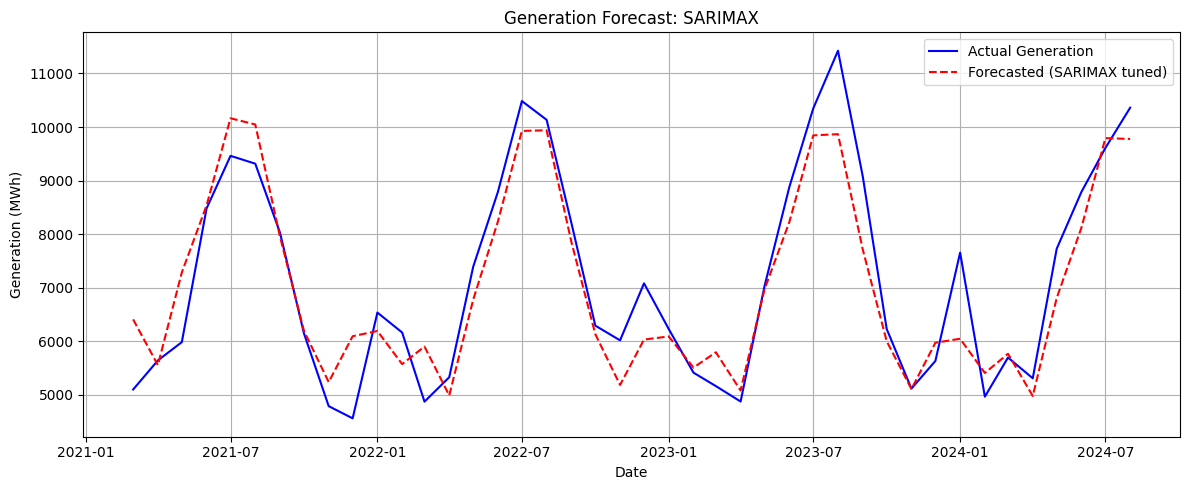

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Actual Generation", color='blue')
plt.plot(pred_test_best.index, pred_test_best, label="Forecasted (SARIMAX tuned)", linestyle='--', color='red')
plt.title("Generation Forecast: SARIMAX")
plt.xlabel("Date")
plt.ylabel("Generation (MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Final Comparison


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
mape_sarimax = mean_absolute_percentage_error(y_test, pred_test_best)
mape_var = mean_absolute_percentage_error(y_test, forecast_gen)


In [ ]:
import plotly.graph_objects as go

# Define traces
trace_actual = go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual Generation', line=dict(color='black'))
trace_xgb = go.Scatter(x=y_test.index, y=y_pred, mode='lines', name=f'XGBoost (MAPE: {mape_xgb*100:.2f}%)', line=dict(color='green'))
trace_sarimax = go.Scatter(x=y_test.index, y=pred_test_best, mode='lines', name=f'SARIMAX (MAPE: {mape_sarimax*100:.2f}%)', line=dict(color='red'))
trace_var = go.Scatter(x=y_test.index, y=forecast_gen, mode='lines', name=f'VAR (MAPE: {mape_var*100:.2f}%)', line=dict(color='orange'))

# Add all traces to the figure
fig = go.Figure(data=[trace_actual, trace_xgb, trace_sarimax, trace_var])

# Define visibility logic for each button (True/False for each trace)
visibility_options = {
    'All': [True, True, True, True],
    'XGBoost': [True, True, False, False],
    'SARIMAX': [True, False, True, False],
    'VAR': [True, False, False, True],
    'XGB + SARIMAX': [True, True, True, False],
    'XGB + VAR': [True, True, False, True],
    'SARIMAX + VAR': [True, False, True, True],
    'Only Actual': [True, False, False, False]
}

# Create updatemenus (buttons on right side)
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="down",
            showactive=True,
            x=1.05,
            y=0.9,
            xanchor="left",
            yanchor="top",
            buttons=[
                dict(label=name, method="update", args=[{"visible": vis}])
                for name, vis in visibility_options.items()
            ]
        )
    ],
    title="Electricity Generation Forecasts: Toggle Models",
    xaxis_title="Date",
    yaxis_title="Generation (MWh)",
    height=500,
    margin=dict(r=200),  # Space for buttons on the right
    legend=dict(x=0.01, y=0.99)
)

fig.show()


# Forecasting into the future

In [ ]:
forecast_horizon = 4


**SARIMAX**

In [ ]:
# Repeat last scaled row 4 times as future exog
X_future_sarimax = pd.DataFrame(
    [X_train_val_scaled.iloc[-1].values] * forecast_horizon,
    columns=X_train_val_scaled.columns
)

# Forecast
sarimax_future = results_best.get_forecast(steps=forecast_horizon, exog=X_future_sarimax)
sarimax_pred = sarimax_future.predicted_mean


**VAR**

In [ ]:
from statsmodels.tsa.api import VAR

# Start with last available window
var_input = df_stationary.iloc[-var_result.k_ar:].copy()
var_preds = []

for _ in range(forecast_horizon):
    pred = var_result.forecast(y=var_input.values[-var_result.k_ar:], steps=1)
    pred_df = pd.DataFrame(pred, columns=var_input.columns)
    var_preds.append(pred_df["Generation(megawatthrs)"].values[0])
    var_input = pd.concat([var_input, pred_df], ignore_index=True)

var_pred = pd.Series(var_preds)


**XGBoost**

In [ ]:
df

,temperature,dew_point_temp,relative_humidity,wind_speed,Generation(megawatthrs),gen_lag_1,gen_lag_2,gen_lag_12,gen_roll_3,gen_roll_6,gen_roll_12,month_num,month_sin,month_cos
2002-01-01,47.476671,33.956044,63.364025,10.968145,12160.43300,18686.43400,17345.41800,22450.33300,16064.095000,19678.111333,21226.921500,1,5.000000e-01,8.660254e-01
2002-02-01,47.086957,32.104948,60.361739,10.732759,10746.05200,12160.43300,18686.43400,18357.42100,13864.306333,16758.454333,20592.640750,2,8.660254e-01,5.000000e-01
2002-03-01,53.730245,41.698910,67.779360,13.704036,11501.99000,10746.05200,12160.43300,19481.59100,11469.491667,14889.503000,19927.674000,3,1.000000e+00,6.123234e-17
2002-04-01,67.780000,58.121429,72.937243,12.469286,11332.61100,11501.99000,10746.05200,20094.17500,11193.551000,13628.823000,19197.543667,4,8.660254e-01,-5.000000e-01
2002-05-01,72.190608,61.749641,71.248633,11.916160,13249.22400,11332.61100,11501.99000,23729.52600,12027.941667,12946.124000,18324.185167,5,5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,68.681250,56.426389,68.500514,12.483889,5305.85996,5693.67136,4962.28861,4871.89542,5320.606643,5726.438497,7278.783342,4,8.660254e-01,-5.000000e-01
2024-05-01,76.885753,66.099462,71.643253,10.615860,7725.75821,5305.85996,5693.67136,7029.36674,6241.763177,6161.846852,7336.815964,5,5.000000e-01,-8.660254e-01
2024-06-01,83.967500,70.156944,65.470833,9.933125,8788.78330,7725.75821,5305.85996,8875.69526,7273.467157,6688.440882,7329.573301,6,1.224647e-16,-1.000000e+00
2024-07-01,84.806191,69.528937,62.654482,9.711456,9609.18538,8788.78330,7725.75821,10347.16390,8707.908963,7014.257803,7268.075091,7,-5.000000e-01,-8.660254e-01


In [ ]:
def forecast_xgb_recursive(df, xgb_model, forecast_horizon=4):
    df_copy = df.copy()
    preds = []
    dates = []

    for i in range(forecast_horizon):
        last_row = df_copy.iloc[-1:].copy()

        # Create next month's date
        next_date = df_copy.index[-1] + pd.DateOffset(months=1)
        dates.append(next_date)

        # Feature engineering for next step
        gen_lag_1 = df_copy["Generation(megawatthrs)"].iloc[-1]
        gen_lag_2 = df_copy["Generation(megawatthrs)"].iloc[-2]
        gen_lag_12 = df_copy["Generation(megawatthrs)"].iloc[-12] if len(df_copy) >= 12 else df_copy["Generation(megawatthrs)"].iloc[0]

        gen_roll_3 = df_copy["Generation(megawatthrs)"].rolling(3).mean().iloc[-1]
        gen_roll_6 = df_copy["Generation(megawatthrs)"].rolling(6).mean().iloc[-1]
        gen_roll_12 = df_copy["Generation(megawatthrs)"].rolling(12).mean().iloc[-1]

        month_num = next_date.month
        month_sin = np.sin(2 * np.pi * month_num / 12)
        month_cos = np.cos(2 * np.pi * month_num / 12)

        # Repeat last known weather features
        weather = df_copy.iloc[-1][["temperature", "dew_point_temp", "relative_humidity", "wind_speed"]]

        # Construct feature row
        feature_row = pd.DataFrame({
            "temperature": [weather["temperature"]],
            "dew_point_temp": [weather["dew_point_temp"]],
            "relative_humidity": [weather["relative_humidity"]],
            "wind_speed": [weather["wind_speed"]],
            "gen_lag_1": [gen_lag_1],
            "gen_lag_2": [gen_lag_2],
            "gen_lag_12": [gen_lag_12],
            "gen_roll_3": [gen_roll_3],
            "gen_roll_6": [gen_roll_6],
            "gen_roll_12": [gen_roll_12],
            "month_num": [month_num],
            "month_sin": [month_sin],
            "month_cos": [month_cos]
        }, index=[next_date])

        # Predict
        y_pred = xgb_model.predict(feature_row.drop(columns=["month_num"]))[0]
        preds.append(y_pred)

        # Append predicted generation to df_copy for next iteration
        new_row = feature_row.copy()
        new_row["Generation(megawatthrs)"] = y_pred
        df_copy = pd.concat([df_copy, new_row], axis=0)

    return pd.Series(preds, index=dates, name="XGBoost Forecast")


In [ ]:
xgb_future_pred = forecast_xgb_recursive(df, best_model, forecast_horizon=4)


In [ ]:
24

24